In [2]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import matplotlib as mpl
import numpy as np
from h5py import File

spots_directory = Path(r"D:\Tracking\DrosophilaNucleusTracking\data\spots")
save_path = Path(r"D:\OneDrive - Princeton University\Lab Meetings\2025_09_15 Shvartsman lab figures\Subfigures")

rc = {
    # "figure.facecolor": "#FFFFFF00",
    # "axes.facecolor": "#FFFFFF00",
    "legend.framealpha": 0.2,
    "lines.color": "k",
    "svg.fonttype": "none",
}

sns.set_context("paper")
sns.set_theme(style="ticks", font="Arial", rc=rc)

# print(mpl.font_manager.get_font_names())
nc_pal = {11: "coral", 12: "mediumseagreen", 13: "cadetblue", 14: "#895794"}
trk_pal = ["steelblue", "gold"]
four_color_pal = ["#44af69", "#f8333c", "#fcab10", "#2b9eb3"]
spots_dfs = []
metadatas = []

for i, spots_path in tqdm(enumerate(spots_directory.glob("*_spots.h5")), desc="reading spots dfs"):
    print(spots_path)
    spots_df = pd.read_hdf(spots_path, key="df")

    spots_df["source"] = i

    metadata = {}

    with File(spots_path, "r") as f:
        m = f["metadata"]
        metadata.update(m.attrs)

    metadatas.append(metadata)

    # print(metadata)

    dtw_path = spots_directory / "dtw" / f"{spots_path.stem}_dtw.h5"
    if dtw_path.exists():
        dtw_update = pd.read_hdf(dtw_path, key="df")
        spots_df = pd.merge(
            spots_df, dtw_update, left_index=True, right_index=True, how="left"
        )
        spots_df["cycle_pseudotime"] = spots_df["pseudotime"] + spots_df["cycle"] - 11
    else:
        spots_df["distance"] = np.nan  # rename this later
        spots_df["pseudotime"] = np.nan

    spots_dfs.append(spots_df)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


reading spots dfs: 0it [00:00, ?it/s]

D:\Tracking\DrosophilaNucleusTracking\data\spots\lightsheet_20241104_spots.h5


reading spots dfs: 1it [00:00,  1.74it/s]

D:\Tracking\DrosophilaNucleusTracking\data\spots\lightsheet_20250131_spots.h5


reading spots dfs: 2it [00:01,  1.72it/s]

D:\Tracking\DrosophilaNucleusTracking\data\spots\lightsheet_20250206_spots.h5


reading spots dfs: 3it [00:01,  1.77it/s]

D:\Tracking\DrosophilaNucleusTracking\data\spots\lightsheet_20250414_spots.h5


reading spots dfs: 4it [00:02,  1.71it/s]

D:\Tracking\DrosophilaNucleusTracking\data\spots\lightsheet_20250625_spots.h5


reading spots dfs: 5it [00:03,  1.37it/s]

D:\Tracking\DrosophilaNucleusTracking\data\spots\lightsheet_20250627_spots.h5


reading spots dfs: 6it [00:03,  1.41it/s]

D:\Tracking\DrosophilaNucleusTracking\data\spots\lightsheet_20250702_spots.h5


reading spots dfs: 7it [00:04,  1.40it/s]

D:\Tracking\DrosophilaNucleusTracking\data\spots\lightsheet_20250704_spots.h5


reading spots dfs: 8it [00:05,  1.38it/s]

D:\Tracking\DrosophilaNucleusTracking\data\spots\lightsheet_20250705_spots.h5


reading spots dfs: 9it [00:06,  1.22it/s]

D:\Tracking\DrosophilaNucleusTracking\data\spots\lightsheet_trk_20250318_spots.h5


reading spots dfs: 10it [00:07,  1.25it/s]

D:\Tracking\DrosophilaNucleusTracking\data\spots\lightsheet_trk_20250319a_spots.h5


reading spots dfs: 11it [00:07,  1.34it/s]

D:\Tracking\DrosophilaNucleusTracking\data\spots\lightsheet_trk_20250319b_spots.h5


reading spots dfs: 12it [00:08,  1.44it/s]

D:\Tracking\DrosophilaNucleusTracking\data\spots\lightsheet_trk_20250321_spots.h5


reading spots dfs: 13it [00:09,  1.36it/s]

D:\Tracking\DrosophilaNucleusTracking\data\spots\lightsheet_trk_20250325_spots.h5


reading spots dfs: 14it [00:09,  1.41it/s]


In [19]:
nc_pal = {cycle: col for cycle, col in zip(
    [10, 11, 12, 13, 14],
    ["#555555", "#44af69", "#f8333c", "#fcab10", "#2b9eb3"]
)}

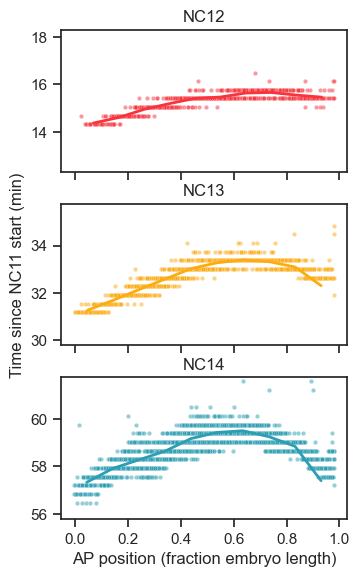

In [26]:
from matplotlib.lines import Line2D

fig, axes = plt.subplots(3, 1, figsize=(1.88*2, 2*2.79), sharex=True, sharey=False)

plt.tight_layout()

i = 1

df = spots_dfs[i]

for cycle, ax in zip([11, 12, 13], axes.flatten()):

    df = df[df["AP"] < 0.98]
    df = df[df["distance"] < 5]

    color = nc_pal[cycle + 1]

    t = df[df["cycle"] == cycle].groupby("tracklet_id")

    x = pd.cut(t["AP"].last(), 10)
    x = x.apply(lambda v: (v.left + v.right) / 2)
    y = np.array(t["time_since_nc11"].max())

    sns.lineplot(x=x, y=y, ax=ax, errorbar=None, color=color, lw=2)
    sns.scatterplot(x=t["AP"].last(), y=y, ax=ax, color=color, s=10, alpha=0.5)

    lims = y.mean()
    distance = 3
    ax.set_ylim(lims - distance, lims + distance)
    ax.set_title(f"NC{cycle + 1}")

axes[-1].set_xlabel("AP position (fraction embryo length)")
axes[1].set_ylabel("Time since NC11 start (min)")

# plt.suptitle("Time of Division", y=1.05, fontsize=16)
plt.savefig(save_path / f"ap_division_time", dpi=300)
plt.show()